In [3]:

import numpy as np
import matplotlib.pyplot as plt
import fixedpoint

import os
from scipy.io import wavfile
from IPython.display import Audio

PLOT = True

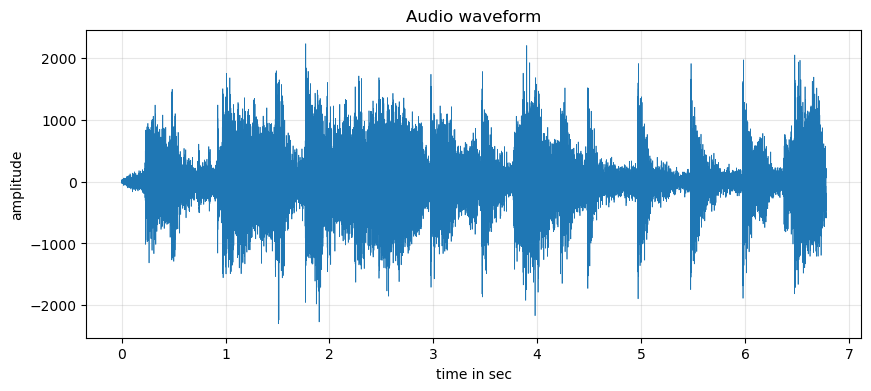

In [5]:
#input audio sample for DSP

tracks_location = "C:/Users/penel/MTRX_3700/Assignment 2"
expected_bpm = 120

input_audio_file = os.path.join(tracks_location, f"{expected_bpm}bpm_music.wav")
Audio(input_audio_file)

fs, signal = wavfile.read(input_audio_file)
signal = signal.astype(np.int64)
signal_length = len(signal) #number of samples in the signal

t = np.linspace(0, signal_length/fs, signal_length)

plt.figure(figsize=(10,4))
plt.plot(t, signal, linewidth=0.5)
plt.xlabel("time in sec")
plt.ylabel("amplitude")
plt.title("Audio waveform")
plt.grid(True, alpha=0.3)
plt.show()

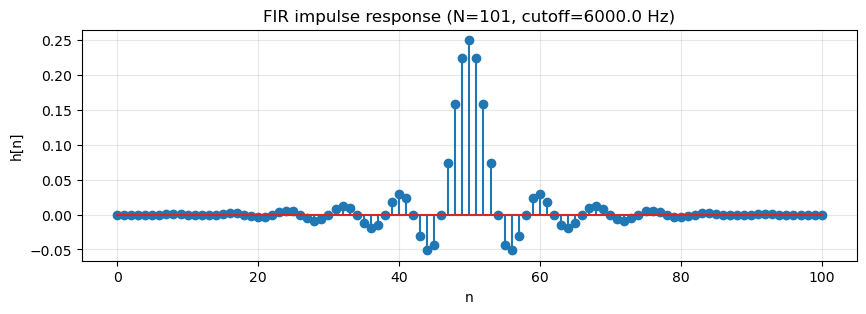

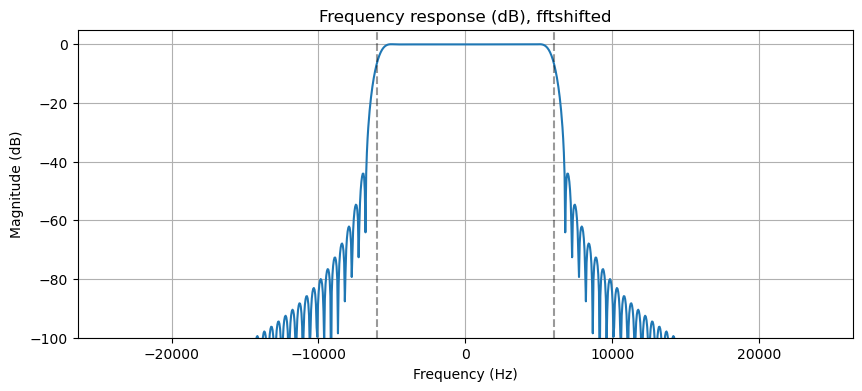

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# -- parameters (example) --
fs = 48000             # sampling rate in Hz (replace with your value)
decimation = 4
N = 101                
fft_len = 1024
cutoff_freq = fs / (2 * decimation)   

# design
M = (N - 1) / 2.0
n = np.arange(N) - M   #center it around M

# normalized cutoff in cycles/sample
fc_norm = cutoff_freq / fs       # cycles-per-sample
# np.sinc (np.sinc(x) = sin(pi x)/(pi x))
h = 2 * fc_norm * np.sinc(2 * fc_norm * n)

# hanning window
h *= np.hanning(N)
h /= np.sum(h)   #normalised it

# plot impulse
plt.figure(figsize=(10,3))
plt.stem(np.arange(N), h)
plt.title(f"FIR impulse response (N={N}, cutoff={cutoff_freq:.1f} Hz)")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.grid(alpha=0.3)

# frequency response 
H = np.fft.fft(h, fft_len)
H_shift = np.fft.fftshift(H)
mag = np.abs(H_shift)
mag_db = 20 * np.log10(mag + 1e-12)   # avoid log(0)

# frequency axis in cycles/sample
freq_norm = np.linspace(-0.5, 0.5, fft_len, endpoint=False)
freq_hz = freq_norm * fs

plt.figure(figsize=(10,4))
plt.plot(freq_hz, mag_db)
plt.axvline(-cutoff_freq, color='k', linestyle='--', alpha=0.4)
plt.axvline(cutoff_freq, color='k', linestyle='--', alpha=0.4)
plt.title("Frequency response (dB), fftshifted")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.ylim([-100, 5])
plt.grid()
plt.show()


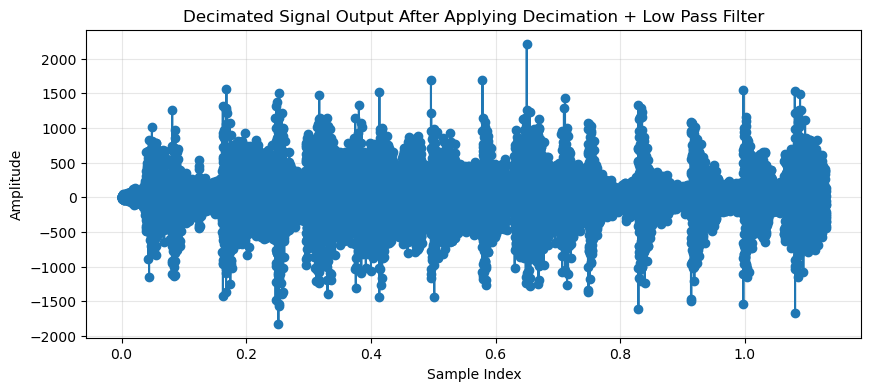

In [17]:
#apply low pass filter
filtered_signal = np.convolve(signal, impulse_response, mode="same")

#decimate
decimation_factor = 4
fs_decimated = fs / decimation_factor #new sampling frequency
decimated_signal = filtered_signal[::decimation_factor]

#plotting
t_decimated = np.linspace(0, len(decimated_signal)/fs_decimated, len(decimated_signal))

plt.figure(figsize=(10,4))
plt.plot(t_decimated, decimated_signal, "-o")
plt.title("Decimated Signal Output After Applying Decimation + Low Pass Filter")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True, alpha = 0.3)

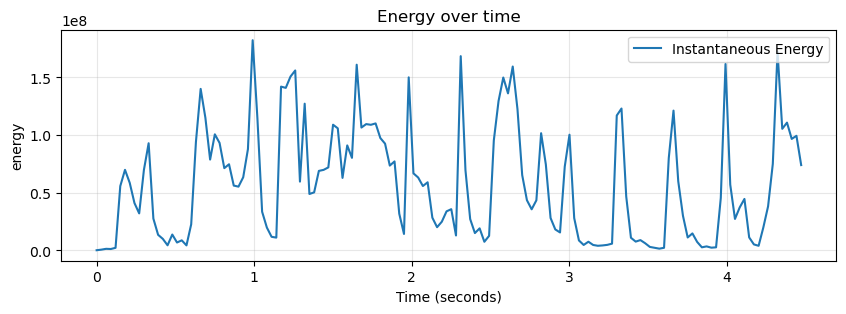

In [19]:
#divide singal into windows
sample_period = 1 / fs_decimated
sample_freq = fs_decimated

threshold = 2
refrac_timer = 150

window_duration = 0.03 #30ms per  window
window_length = int(sample_freq * window_duration)
refrac_cycles = sample_freq * refrac_timer

#calculate number of windows
num_windows = np.round(signal_length/window_length).astype(int)
energy = np.zeros(num_windows - 1)

#energy for each window
for i in range(num_windows - 1):
    window_start = i * window_length
    window_end = (i + 1) * window_length
    window_samples = signal[window_start:window_end]

    energy[i] = np.sum(window_samples ** 2)

#plotting energy
energy_time = np.arange(len(energy)) * window_duration
plt.figure(figsize=(10,3))
plt.plot(energy_time, energy, label='Instantaneous Energy')
plt.xlabel("Time (seconds)")
plt.ylabel("energy")
plt.title("Energy over time")
plt.legend()
plt.grid(True, alpha=0.3)

Estimated BPM from energy peaks: 114.75


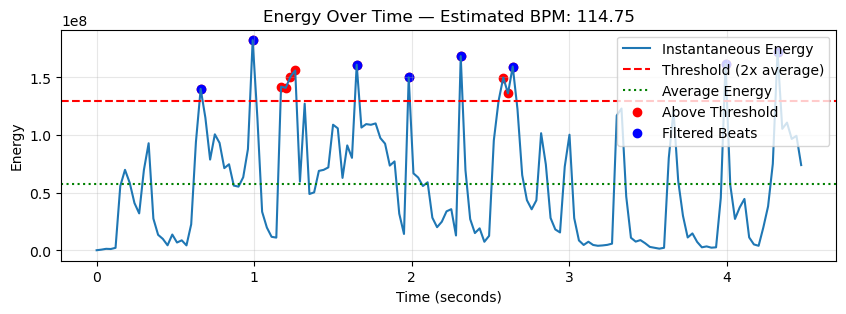

In [35]:
#thresholding

average_energy = np.mean(energy)
threshold = 2.25 * average_energy
beat_times = energy_time[energy > threshold]

refractory_period = 0.3  # seconds (150 ms)
filtered_beats = []

last_beat_time = -np.inf
for t in beat_times:
    if t - last_beat_time >= refractory_period:
        filtered_beats.append(t)
        last_beat_time = t

filtered_beats = np.array(filtered_beats)

if len(filtered_beats) >= 2:
    intervals = np.diff(filtered_beats)  # time between beats
    avg_interval = np.mean(intervals)
    estimated_bpm = 60 / avg_interval
else:
    estimated_bpm = 0  # not enough beats to estimate

print(f"Estimated BPM from energy peaks: {estimated_bpm:.2f}")

plt.figure(figsize=(10, 3))
plt.plot(energy_time, energy, label='Instantaneous Energy')
plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold (2x average)')
plt.axhline(average_energy, color='g', linestyle=':', label='Average Energy')
plt.scatter(beat_times, energy[energy > threshold], color='red', label='Above Threshold')
plt.scatter(filtered_beats, energy[np.searchsorted(energy_time, filtered_beats)], color='blue', label='Filtered Beats')
plt.xlabel("Time (seconds)")
plt.ylabel("Energy")
plt.title(f"Energy Over Time — Estimated BPM: {estimated_bpm:.2f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
